# Simulate long-range migration edge 

As an initial attempt, I will just add a **single** long range migration edge to a specific internal node **on top** of the original triangular lattice from before. I can envision using a greedy approach to fitting this likelihood function by adding a penalty term for which two nodes gets this edge...

Here, I will test the output of the function as I am developing it (code adapted from `sandbox.ipynb`)

## Changes to original code base:
1. adding function `setup_graph_long_range` in `sim.py`

## Imports

In [149]:
%load_ext autoreload
%autoreload 2

# base
import numpy as np
import networkx as nx
from pandas_plink import read_plink
from sklearn.impute import SimpleImputer
import pkg_resources
import itertools as it

# viz
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# feems
from feems.utils import prepare_graph_inputs
from feems import SpatialGraph, Viz
from feems.sim import setup_graph, setup_graph_long_range, simulate_genotypes
from feems.spatial_graph import query_node_attributes

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Testing function + visualization
*Note: nodes are numbered left-right, bottom-top by default in `networkx`*

In [197]:
## using 1.0 to ensure all nodes are sampled equally well (default params otherwise: 4x8 grid)
graph, coord, grid, edge = setup_graph_long_range(corridor_w=1.0, barrier_w=0.5, barrier_prob=1.0, long_range_nodes=[(0,12)], long_range_edges=[2.0])

In [198]:
gen_test = simulate_genotypes(graph)

Simulating ~SNP 0
Simulating ~SNP 100
Simulating ~SNP 250
Simulating ~SNP 400
Simulating ~SNP 450
Simulating ~SNP 500
Simulating ~SNP 550
Simulating ~SNP 650
Simulating ~SNP 700
Simulating ~SNP 750
Simulating ~SNP 800
Simulating ~SNP 850
Simulating ~SNP 950


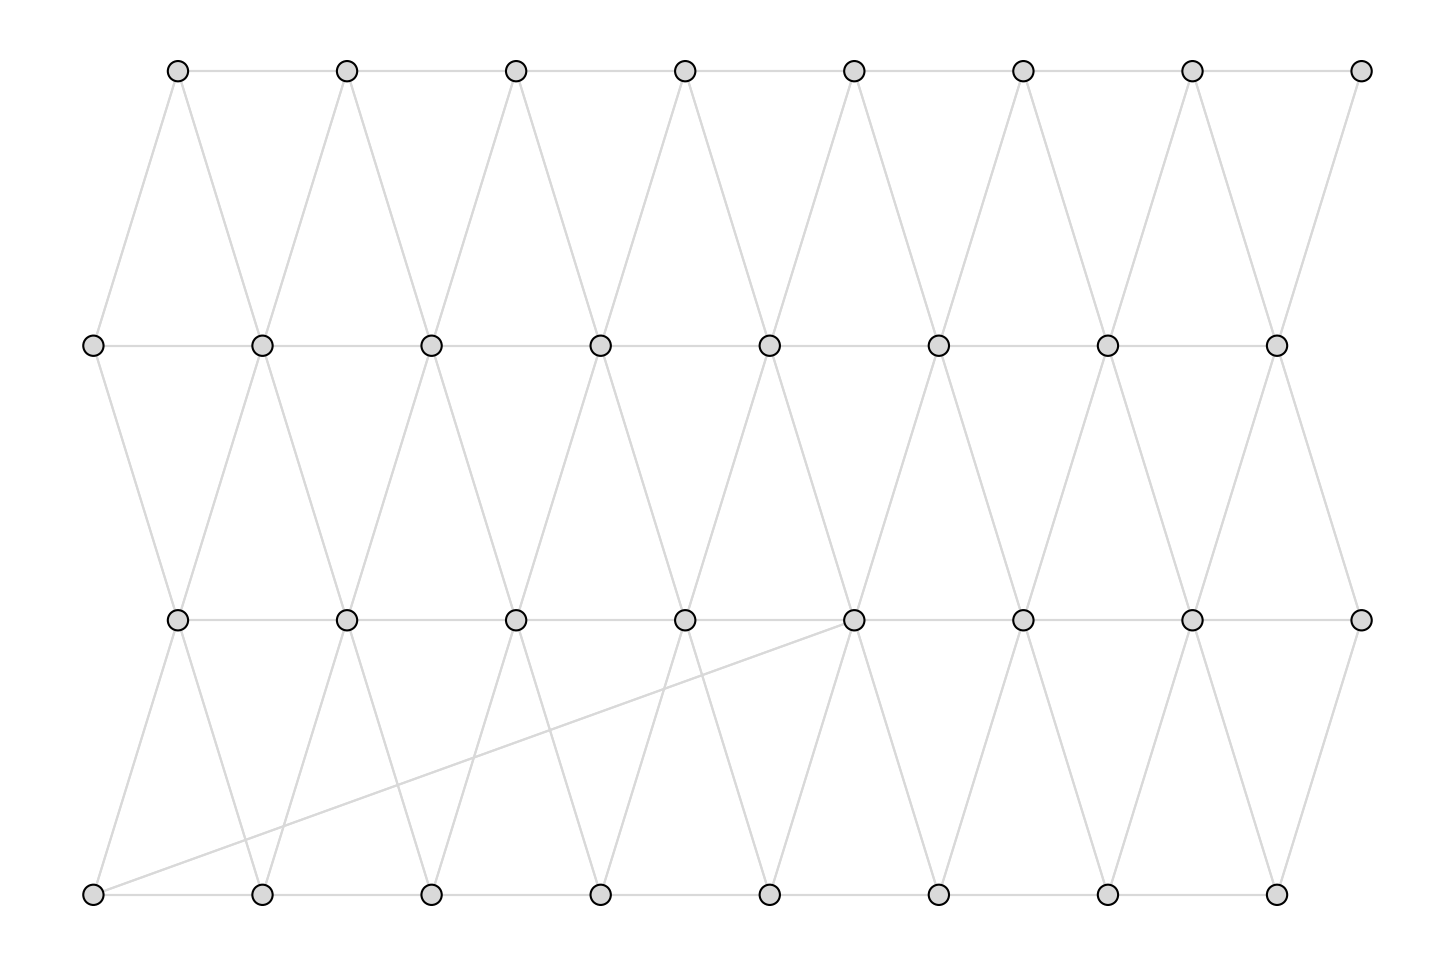

In [205]:
# constructing the graph object
sp_Graph = SpatialGraph(gen_test, coord, grid, edge)

proj_test = ccrs.EquidistantConic(central_longitude=5.5, central_latitude=3.0)
# drawing the simulated graph 
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1)  
v = Viz(ax, sp_Graph, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_samples()
v.draw_edges(use_weights=False)
v.draw_obs_nodes(use_ids=False)

## Default `feems` fit  

In [191]:
%%time
#sp_Graph.fit_null_model()
sp_Graph.fit(lamb = 1.0)

constant-w/variance fit, converged in 127 iterations, train_loss=14594.3077356
lambda=1.0000000, alpha=1.4524581, converged in 12 iterations, train_loss=12900.1727725
CPU times: user 1.14 s, sys: 25.3 ms, total: 1.16 s
Wall time: 339 ms


As expected, the long range edge weight is found to be approximately 1, meaning there is no migration along this edge. 

In [192]:
sp_Graph.w

array([1.21190847, 1.31291105, 0.91072699, 1.43243922, 1.69111152,
       1.63143604, 1.30138963, 1.44304831, 0.90277036, 0.36372127,
       0.36434383, 0.23536608, 0.28870699, 0.24820141, 0.38505339,
       1.10574067, 0.20700477, 0.47502198, 1.58500402, 1.12773006,
       1.60116013, 2.0168943 , 2.22035019, 1.43997428, 1.68584757,
       1.45070089, 0.90728653, 1.56017249, 1.19720947, 0.28204255,
       0.77273881, 0.28164229, 0.269195  , 0.18886748, 0.1876038 ,
       0.46921804, 0.2086575 , 0.3433728 , 1.3812393 , 0.52488828,
       0.8906579 , 2.18944995, 1.56562812, 1.60536049, 1.75236358,
       1.7948741 , 2.15621737, 1.28386297, 1.63397672, 1.67128803,
       0.87698658, 1.01466052, 1.37529758, 0.21230064, 0.3656463 ,
       0.33703997, 0.31030467, 0.20125472, 0.16047944, 1.11588964,
       0.3704515 , 0.28430407, 1.6785936 , 0.57188804, 0.97145688,
       1.37449286, 1.65140476, 2.01948073, 1.0176029 , 0.30442093,
       0.31290279, 0.1673369 , 0.89727195, 1.00500773])

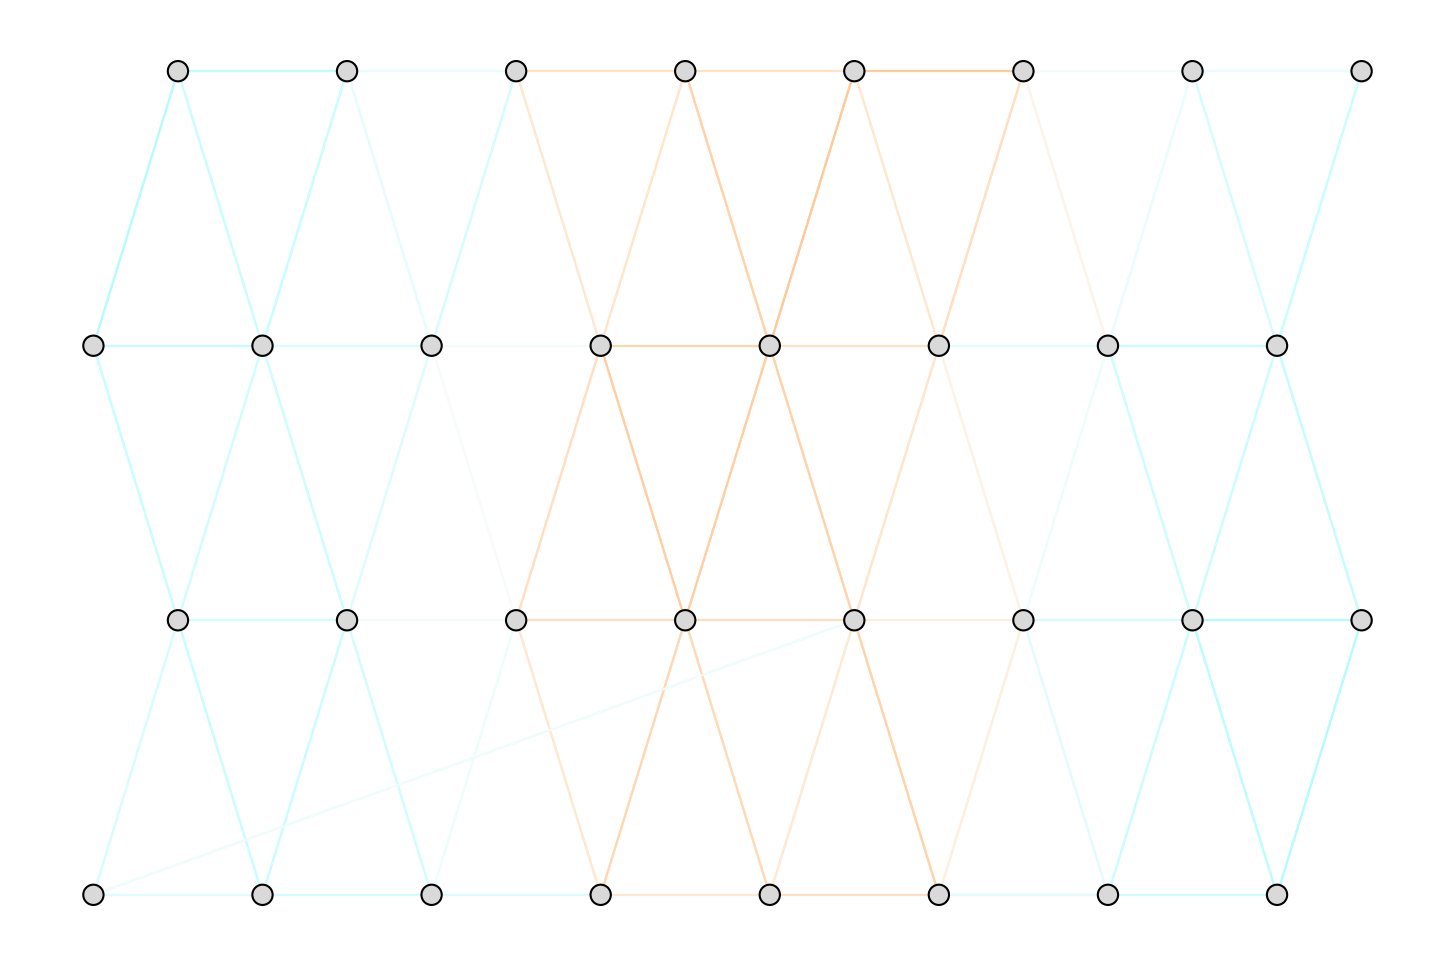

In [193]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1)  
v = Viz(ax, sp_Graph, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 